### AIT 614 - Big Data Essentials <br>
#### DL2 Team 3 Final Project
#### Detecting Abrasive online user content

##### Team 3
Yasser Parambathkandy

Indranil Pal

Deepak Rajan

<br>

##### University
George Mason University


##### Installation

###### Databricks:
On an existing cluster, add the following to the Advanced Options -> Spark tab:
```
  spark.kryoserializer.buffer.max 2000M
  spark.serializer org.apache.spark.serializer.KryoSerializer
```

In Libraries tab inside the cluster:
  * Install New -> PyPI -> spark-nlp==4.4.0 -> Install
  * Install New -> Maven -> Coordinates -> com.johnsnowlabs.nlp:spark-nlp_2.12:4.4.0 -> Install

Refer https://github.com/JohnSnowLabs/spark-nlp#databricks-cluster for installation issues

###### Local Machine:
See README
<br>

##### Data load

Upload train.csv to databricks. It should get loaded to dbfs:/FileStore/tables/train.csv
For local development, update train.csv file path in second cell below
<br>
##### Saving Model

Save model to use in real-time prediction services. The model gets saved to S3 bucket if runtime environment is databricks and AWS accesskey csv has been uploaded to dbfs:/FileStore/tables/ait614_databricks_accessKeys.csv. If either condition is not satisfied, then model is not saved in databricks. To overwrite the file path, bucket name, update properties in second cell below
For local development, model is always saved.

Saved model is used by prediction services when user enter new questions in UI.

In [18]:
import os
import datetime

import matplotlib.pyplot as plt
import sparknlp
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.linalg import VectorUDT
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col, udf, lit
from pyspark.sql.types import ArrayType, DoubleType
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score
from sparknlp.annotator import *
from sparknlp.base import *

In [19]:
#set properties for local machine development and databricks

# check if running in Databricks by looking for the DATABRICKS_RUNTIME_VERSION environment variable
is_env_databricks = False
is_aws_access_file_loaded = False
if "DATABRICKS_RUNTIME_VERSION" in os.environ:
    # set the CSV file path for Databricks
    train_file_path = 'dbfs:/FileStore/tables/train.csv'
    aws_s3_keys = 'dbfs:/FileStore/tables/ait614_databricks_accessKeys.csv'
    s3_mount_path = '/mnt/ait614-models'
    s3_bucket_name = 'ait614-models'
    is_env_databricks = True
    try:
        dbutils.fs.ls(aws_s3_keys)
        is_aws_access_file_loaded = True
    except:
        print('aws key not loaded, model will not be saved to s3')
else:
    # set the training file path for local machine. when running in jupyter notebook relative path doesn't work, so provide full path
    train_file_path = '/opt/ait614/AIT614-DL2_Team3_sys/data/train.csv'
    spark = sparknlp.start()

print('training file path {}'.format(train_file_path))

23/04/23 12:03:14 WARN Utils: Your hostname, DESKTOP-7N61Q81 resolves to a loopback address: 127.0.1.1; using 172.26.165.188 instead (on interface eth0)
23/04/23 12:03:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Ivy Default Cache set to: /home/yarafatin/.ivy2/cache
The jars for the packages stored in: /home/yarafatin/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-2a35eb90-a49f-486e-8b05-856d3e1e2be5;1.0
	confs: [default]


:: loading settings :: url = jar:file:/home/yarafatin/softwares/anaconda3/envs/ait614/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found com.johnsnowlabs.nlp#spark-nlp_2.12;4.4.0 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1.16.8 in central
	found com.google.cloud#google-cloud-storage;2.16.0 in central
	found com.google.guava#guava;31.1-jre in central
	found com.google.guava#failureaccess;1.0.1 in local-m2-cache
	found com.google.guava#listenablefuture;9999.0-empty-to-avoid-conflict-with-guava in local-m2-cache
	found com.google.errorprone#error_prone_annotations;2.16 in central
	found com.google.j2objc#j2objc-annotations;1.3 in local-m2-cache
	found com.google.http-clie

training file path /home/yarafatin/PycharmProjects/AIT-614-Final/data/train.csv
training file path /home/yarafatin/PycharmProjects/AIT-614-Final/data/train.csv


In [20]:
# Read the CSV file
schema = "qid STRING, question_text STRING, target INT"
df = spark.read.option("header", "true")\
        .option("delimiter", ",")\
        .option("multiLine", "true")\
        .option("quote", "\"")\
        .option("escape", "\"")\
        .schema(schema).csv(train_file_path)

# databricks timesout for 1 million. It runs for 2 hours and then the instance is terminated
# reducing to 100K to run end-to-end
if "DATABRICKS_RUNTIME_VERSION" in os.environ:
    df = df.limit(100000)

df.printSchema()
df.show(10)

root
 |-- qid: string (nullable = true)
 |-- question_text: string (nullable = true)
 |-- target: integer (nullable = true)

+--------------------+--------------------+------+
|                 qid|       question_text|target|
+--------------------+--------------------+------+
|00002165364db923c7e6|How did Quebec na...|     0|
|000032939017120e6e44|Do you have an ad...|     0|
|0000412ca6e4628ce2cf|Why does velocity...|     0|
|000042bf85aa498cd78e|How did Otto von ...|     0|
|0000455dfa3e01eae3af|Can I convert mon...|     0|
|00004f9a462a357c33be|Is Gaza slowly be...|     0|
|00005059a06ee19e11ad|Why does Quora au...|     0|
|0000559f875832745e2e|Is it crazy if I ...|     0|
|00005bd3426b2d0c8305|Is there such a t...|     0|
|00006e6928c5df60eacb|Is it just me or ...|     0|
+--------------------+--------------------+------+
only showing top 10 rows

root
 |-- qid: string (nullable = true)
 |-- question_text: string (nullable = true)
 |-- target: integer (nullable = true)

+---------

In [21]:
#takes a long time to download, so please be patient
embeddings = WordEmbeddingsModel.pretrained("glove_840B_300", "xx").setInputCols("document", "token").setOutputCol(
    "embeddings")

glove_840B_300 download started this may take some time.
Approximate size to download 2.3 GB
[ | ]glove_840B_300 download started this may take some time.
Approximate size to download 2.3 GB
Download done! Loading the resource.
[OK!]
glove_840B_300 download started this may take some time.
Approximate size to download 2.3 GB
[OK!]


In [22]:
document_assembler = DocumentAssembler().setInputCol("question_text").setOutputCol("document")
tokenizer = Tokenizer().setInputCols(["document"]).setOutputCol("token")

In [23]:
nlpPipeline = Pipeline(stages=[document_assembler,
                               tokenizer,
                               embeddings])

df = nlpPipeline.fit(df).transform(df)

In [24]:
def avg_vectors(word_vectors):
    length = len(word_vectors[0]["embeddings"])
    avg_vec = [0] * length
    for vec in word_vectors:
        for i, x in enumerate(vec["embeddings"]):
            avg_vec[i] += x
        avg_vec[i] = avg_vec[i] / length
    return avg_vec


def dense_vector(vec):
    return Vectors.dense(vec)

In [25]:
# create a udf
avg_vectors_udf = udf(avg_vectors, ArrayType(DoubleType()))
df_doc_vec = df.withColumn("doc_vector", avg_vectors_udf(col("embeddings")))
df_doc_vec.show(10)

+--------------------+--------------------+------+--------------------+--------------------+--------------------+--------------------+
|                 qid|       question_text|target|            document|               token|          embeddings|          doc_vector|
+--------------------+--------------------+------+--------------------+--------------------+--------------------+--------------------+
|00002165364db923c7e6|How did Quebec na...|     0|[{document, 0, 71...|[{token, 0, 2, Ho...|[{word_embeddings...|[0.38199613126926...|
|000032939017120e6e44|Do you have an ad...|     0|[{document, 0, 80...|[{token, 0, 1, Do...|[{word_embeddings...|[-0.7888190010562...|
|0000412ca6e4628ce2cf|Why does velocity...|     0|[{document, 0, 66...|[{token, 0, 2, Wh...|[{word_embeddings...|[0.04380194842815...|
|000042bf85aa498cd78e|How did Otto von ...|     0|[{document, 0, 56...|[{token, 0, 2, Ho...|[{word_embeddings...|[1.12683903053402...|
|0000455dfa3e01eae3af|Can I convert mon...|     0|[{doc

+--------------------+--------------------+------+--------------------+--------------------+--------------------+--------------------+
|                 qid|       question_text|target|            document|               token|          embeddings|          doc_vector|
+--------------------+--------------------+------+--------------------+--------------------+--------------------+--------------------+
|00002165364db923c7e6|How did Quebec na...|     0|[{document, 0, 71...|[{token, 0, 2, Ho...|[{word_embeddings...|[0.38199613126926...|
|000032939017120e6e44|Do you have an ad...|     0|[{document, 0, 80...|[{token, 0, 1, Do...|[{word_embeddings...|[-0.7888190010562...|
|0000412ca6e4628ce2cf|Why does velocity...|     0|[{document, 0, 66...|[{token, 0, 2, Wh...|[{word_embeddings...|[0.04380194842815...|
|000042bf85aa498cd78e|How did Otto von ...|     0|[{document, 0, 56...|[{token, 0, 2, Ho...|[{word_embeddings...|[1.12683903053402...|
|0000455dfa3e01eae3af|Can I convert mon...|     0|[{doc

In [26]:
dense_vector_udf = udf(dense_vector, VectorUDT())
word_df = df_doc_vec.withColumn("features", dense_vector_udf(col("doc_vector")))

In [27]:
# split train and test data
# code inspired from https://stackoverflow.com/questions/47637760/stratified-sampling-with-pyspark
split_ratio = 0.8
seed = 42
fractions = word_df.select('target').distinct().withColumn("fraction", lit(split_ratio)).filter(
    'fraction is not null').rdd.collectAsMap()

train_df = word_df.stat.sampleBy('target', fractions, seed)
test_df = word_df.join(train_df, on='qid', how="left_anti")

In [28]:
lr = LogisticRegression(labelCol="target", featuresCol="features", maxIter=10, regParam=0.3, elasticNetParam=0.8)
lrModel = lr.fit(train_df)

23/04/23 12:32:11 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/04/23 12:32:11 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


In [29]:
predictions = lrModel.transform(test_df)
predictions.select("target", "prediction").show(n=10, truncate=30)

+------+----------+
|target|prediction|
+------+----------+
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     1|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
+------+----------+
only showing top 10 rows



+------+----------+
|target|prediction|
+------+----------+
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     1|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
+------+----------+
only showing top 10 rows



In [30]:
# model performance evaluations
pred_df = predictions.select('target', 'prediction').toPandas()
print(classification_report(pred_df.target, pred_df.prediction))
print(accuracy_score(pred_df.target, pred_df.prediction))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97    244581
           1       0.00      0.00      0.00     16227

    accuracy                           0.94    260808
   macro avg       0.47      0.50      0.48    260808
weighted avg       0.88      0.94      0.91    260808

0.9377818165086961


/home/yarafatin/softwares/anaconda3/envs/ait614/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yarafatin/softwares/anaconda3/envs/ait614/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yarafatin/softwares/anaconda3/envs/ait614/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

              precision    recall  f1-score   support

           0       0.94      1.00      0.97    244581
           1       0.00      0.00      0.00     16227

    accuracy                           0.94    260808
   macro avg       0.47      0.50      0.48    260808
weighted avg       0.88      0.94      0.91    260808

0.9377818165086961


/home/yarafatin/softwares/anaconda3/envs/ait614/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yarafatin/softwares/anaconda3/envs/ait614/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yarafatin/softwares/anaconda3/envs/ait614/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

In [31]:
# Compute AUC-ROC
binary_evaluator = BinaryClassificationEvaluator(labelCol="target", rawPredictionCol="prediction",
                                                 metricName="areaUnderROC")
auc_roc = binary_evaluator.evaluate(predictions)
print("AUC-ROC: {:.2f}%".format(auc_roc * 100))

AUC-ROC: 50.00%


AUC-ROC: 50.00%


In [32]:
# Compute AUC-PR
binary_evaluator = BinaryClassificationEvaluator(labelCol="target", rawPredictionCol="prediction",
                                                 metricName="areaUnderPR")
auc_pr = binary_evaluator.evaluate(predictions)
print("AUC-PR: {:.2f}%".format(auc_pr * 100))

AUC-PR: 6.22%


AUC-PR: 6.22%


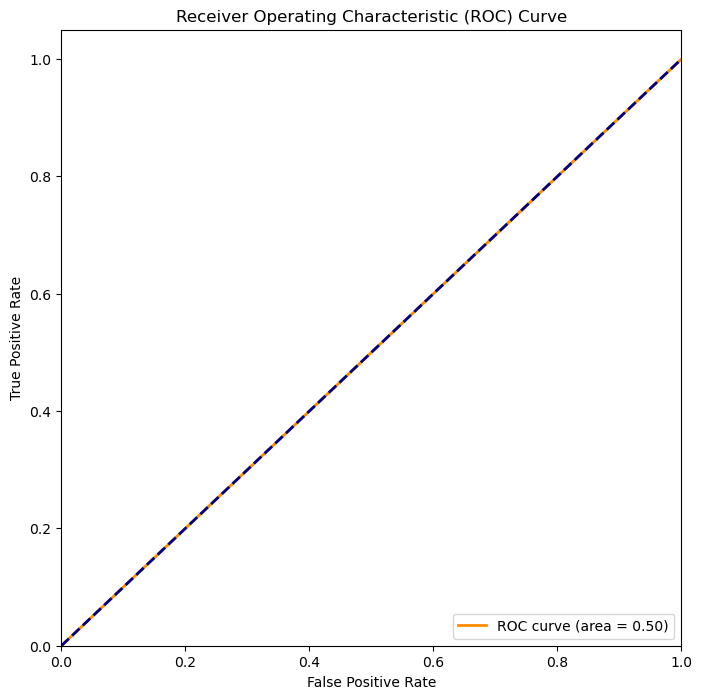

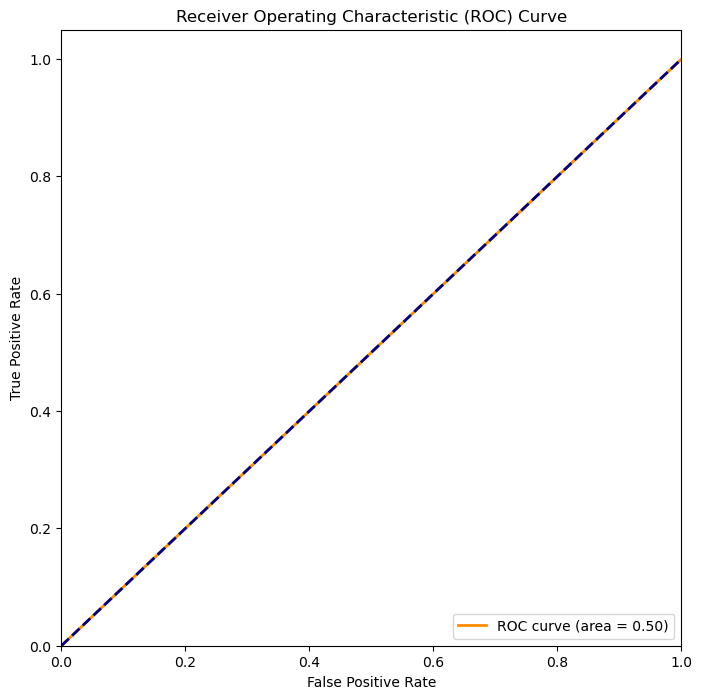

In [33]:
# Plot ROC curve
results = predictions.select(['probability', 'target']).collect()
results_list = [(float(i[0][1]), 1.0 - float(i[1])) for i in results]
fpr, tpr, _ = roc_curve([i[1] for i in results_list], [i[0] for i in results_list])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [34]:
# save model. if running in databricks save to s3.
model_save_dir = datetime.datetime.now().strftime("%Y%m%d%H%M%S") + '-word-model'

if is_env_databricks:
    if is_aws_access_file_loaded:
        aws_keys_df = spark.read.option("header", "true").option("delimiter", ",").csv(aws_s3_keys)

        ACCESS_KEY = aws_keys_df.select('Access key ID').collect()[0]['Access key ID']
        SECRET_KEY = aws_keys_df.select('Secret access key').collect()[0]['Secret access key']
        ENCODED_SECRET_KEY = SECRET_KEY.replace("/", "%2F")
        # mount s3 if not already mounted
        try:
            dbutils.fs.ls(s3_mount_path)
        except:
            # see https://docs.databricks.com/dbfs/mounts.html#mount-a-bucket-using-aws-keys for reference
            dbutils.fs.mount(f"s3a://{ACCESS_KEY}:{ENCODED_SECRET_KEY}@{s3_bucket_name}", s3_mount_path)
        lrModel.save(s3_mount_path + '/' + model_save_dir)
        print('model saved to s3 - ' + model_save_dir)
else:
    lrModel.save(model_save_dir)
    print('model saved to local machine - ' + model_save_dir)

model saved to local machine - 20230423123650-word-model
model saved to local machine - 20230423131034-word-model
